In [1]:
import pandas as pd
import bs4 as bs
import urllib.request

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Importing data from the website in a dataframe format

url = 'https://www.tdcj.texas.gov/death_row/dr_executed_offenders.html'
death_row = pd.read_html(url)[0]
death_row.head()

,Execution,Link,Link.1,Last Name,First Name,TDCJNumber,Age,Date,Race,County
0,570,Offender Information,Last Statement,Wardlow,Billy,999137,45,7/8/2020,White,Titus
1,569,Offender Information,Last Statement,Ochoa,Abel,999450,47,2/6/2020,Hispanic,Dallas
2,568,Offender Information,Last Statement,Gardner,John,999516,64,1/15/2020,White,Collin
3,567,Offender Information,Last Statement,Runnels,Travis,999505,46,12/11/2019,Black,Potter
4,566,Offender Information,Last Statement,Hall,Justen,999497,38,11/6/2019,White,El Paso


In [3]:
#Removing unnecessary and unmeaningful columns

death_row = death_row.drop(['Execution', 'Link'], axis = 1)
death_row.head(10)

,Link.1,Last Name,First Name,TDCJNumber,Age,Date,Race,County
0,Last Statement,Wardlow,Billy,999137,45,7/8/2020,White,Titus
1,Last Statement,Ochoa,Abel,999450,47,2/6/2020,Hispanic,Dallas
2,Last Statement,Gardner,John,999516,64,1/15/2020,White,Collin
3,Last Statement,Runnels,Travis,999505,46,12/11/2019,Black,Potter
4,Last Statement,Hall,Justen,999497,38,11/6/2019,White,El Paso
5,Last Statement,Sparks,Robert,999542,45,9/25/2019,Black,Dallas
6,Last Statement,Soliz,Mark,999571,37,9/10/2019,Hispanic,Johnson
7,Last Statement,Crutsinger,Billy,999459,64,9/4/2019,White,Tarrant
8,Last Statement,Swearingen,Larry,999361,48,8/21/2019,White,Montgomery
9,Last Statement,King,John,999295,44,4/24/2019,White,Jasper


In order to access the last statement of each person from the table, we have to access its corresponding URL.
This URL is located inside of the "Last Statement" column. We can observe the fact that all the URLs follow the
same pattern: base part of the link "https://www.tdcj.texas.gov/death_row/dr_info/" + the information about
that particular person "brookscharlie"(Brooks, Charlie) + this string: "last.html". We can exploit this pattern to scrape the last statement for every single member of the dataframe by generating its own URL extension derived from  existing information(first and last names).

In [4]:
#Creating a helper function that will combine the first and the last name of each prisoner in a proper string format
#that we can then use in the next function for creating individual URLs

def clean_last_name(last_name):
    
    cleaned_last_name = []
    for ln in last_name:
        if "," in ln:
            ln = ln[:-5]
        if "'" in ln:
            ln = ln.replace("'", "")
        cleaned_last_name.append(ln)
        
    return cleaned_last_name

death_row["Last Name"] = clean_last_name(death_row["Last Name"])
death_row.head(10)

,Link.1,Last Name,First Name,TDCJNumber,Age,Date,Race,County
0,Last Statement,Wardlow,Billy,999137,45,7/8/2020,White,Titus
1,Last Statement,Ochoa,Abel,999450,47,2/6/2020,Hispanic,Dallas
2,Last Statement,Gardner,John,999516,64,1/15/2020,White,Collin
3,Last Statement,Runnels,Travis,999505,46,12/11/2019,Black,Potter
4,Last Statement,Hall,Justen,999497,38,11/6/2019,White,El Paso
5,Last Statement,Sparks,Robert,999542,45,9/25/2019,Black,Dallas
6,Last Statement,Soliz,Mark,999571,37,9/10/2019,Hispanic,Johnson
7,Last Statement,Crutsinger,Billy,999459,64,9/4/2019,White,Tarrant
8,Last Statement,Swearingen,Larry,999361,48,8/21/2019,White,Montgomery
9,Last Statement,King,John,999295,44,4/24/2019,White,Jasper


In [5]:
#This is the main function where we finish the process of creating valid URLs

full_names = death_row.apply(lambda row: row["Last Name"] + row["First Name"], axis=1)
def create_url(list_of_names):
    
    URLs = []
    for name in full_names:
        url = "https://www.tdcj.texas.gov/death_row/dr_info/" + name.lower() + "last.html"
        url = url.replace(" ", "") 
        URLs.append(url)
    
    return URLs

URLs = create_url(full_names)
print (URLs[:10])

['https://www.tdcj.texas.gov/death_row/dr_info/wardlowbillylast.html', 'https://www.tdcj.texas.gov/death_row/dr_info/ochoaabellast.html', 'https://www.tdcj.texas.gov/death_row/dr_info/gardnerjohnlast.html', 'https://www.tdcj.texas.gov/death_row/dr_info/runnelstravislast.html', 'https://www.tdcj.texas.gov/death_row/dr_info/halljustenlast.html', 'https://www.tdcj.texas.gov/death_row/dr_info/sparksrobertlast.html', 'https://www.tdcj.texas.gov/death_row/dr_info/solizmarklast.html', 'https://www.tdcj.texas.gov/death_row/dr_info/crutsingerbillylast.html', 'https://www.tdcj.texas.gov/death_row/dr_info/swearingenlarrylast.html', 'https://www.tdcj.texas.gov/death_row/dr_info/kingjohnlast.html']


In [6]:
#A function that loops through all URLs we have just created
#and scrapes the last statement of every single prisoner

def get_last_statements(URL_list):
    
    statements = []
    for url in URL_list:
        try:
            source = urllib.request.urlopen(url).read()
            soup = bs.BeautifulSoup(source, 'lxml')
            statement = soup.find_all('p')[-1].text 
            statements.append(statement)
            
        except: 
            statements.append('null')
            continue;
    
    return statements  

last_statements = get_last_statements(URLs)

In [7]:
len(last_statements)

570

In [8]:
print(last_statements[:10])

['No statement given.', '\xa0', 'Thank you thank you  where’s the family, ok I would like to say sorry for the grief I have caused. I  hope you find peace, joy and closure. Whatever it takes to forgive me. I am  sorry. I know you cannot forgive me but I hope one day you will. To my friends,  I love ya’ll. You have been good and such good influence people. I want to see  the Lord Jesus so bad. I hope you all understand. I am going to ask the Warden  to start. And ask Jesus to help them to forgive me one day please. I am very  sorry. For you guys I love you. Thank you Warden.', '\xa0', '\xa0', 'Umm, Pamela can you  hear me Stephanie, Hardy, Marcus tell all the family I love them. I am sorry  for the hard times and what hurts me is that I hurt y’all and um even for y’all  too and Patricia she wrote me tell Patricia I wrote her back and to tell y’all what  I said. I love y’all. I am ready', 'null', 'Hi ladies I wanted to  tell ya’ll how much I love you. Thank you for being here for me. You

Now that I have extracted the data, I am going to use some simple methods from the NLTK library to clean it. This will allow me to perform analysis.

In [9]:
#Creating one giant body of text from the list of statements, and then separating it into words

all_text = ', '.join(last_statements)
all_words = word_tokenize(all_text)

len(all_words)

46005

In [19]:
#Removing common words without meaning / punctuation. Comparing the number of words before and after this step tells us that
#around 27.000 words have been removed

stop_words = set(stopwords.words("english"))
punctuation = ['.', ',', '’', ':', 'I']
for word in all_words:
    if word in stop_words or word in punctuation:
        all_words.remove(word)
        
len(all_words)

19348

Now that the data is clean, we can perform exploratory analysis on our data-set. 

In [20]:
#Let's look at the most frequent words

most_frequent = FreqDist(all_words)
most_frequent.most_common(20)

[('love', 624),
 ('family', 278),
 ('know', 272),
 ("n't", 232),
 ("'s", 206),
 ('sorry', 205),
 ('want', 199),
 ('would', 193),
 ('God', 188),
 ('like', 179),
 ('say', 150),
 ('thank', 145),
 ('Lord', 143),
 ('You', 137),
 ('life', 125),
 ('forgive', 124),
 ('null', 121),
 ('going', 119),
 ('hope', 115),
 ('Thank', 110)]

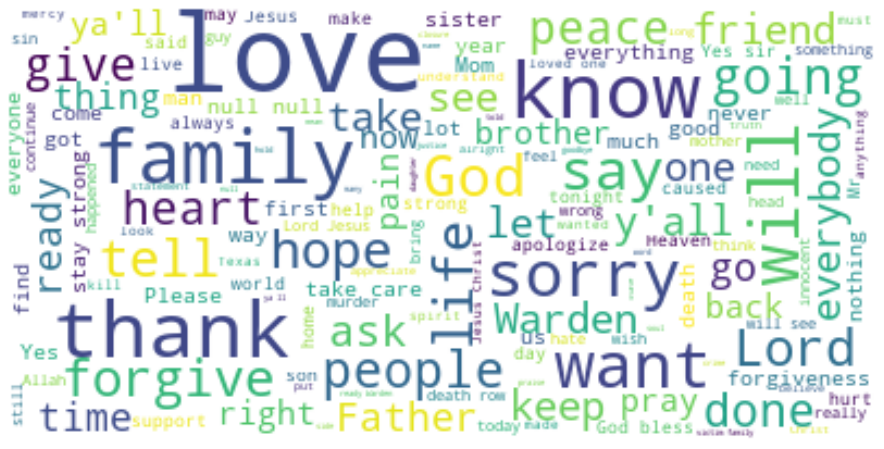

In [21]:
#Generating and displaying a word cloud

wordcloud = WordCloud(max_font_size=50, max_words=150, background_color="white").generate(all_text)

plt.figure(figsize=(18,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

We can observe the most common themes of last statements from the word cloud. Dominant themes seem to be Religion, Forgiveness or Gratitude, and Family.